In [1]:
import arviz as az
import numpy as np
import pandas as pd
import scipy as sp
import altair as alt

import pymc as pm
import pytensor.tensor as pt
import xarray as xr

from utils import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

trace_dict = {}


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Data Loading

In [2]:
data_file = "./data/ee.csv"
data = pd.read_csv(data_file,index_col=0)

# For some reason all observations in Jõgeva- and Tartumaa have their urban_rural values missing, 
# let's fill them with Rural so that we won't have to deal with missing data in post-stratification
data['urban_rural'] = data['urban_rural'].fillna('Rural')

data.head()



,age_group,education,gender,nationality,urban_rural,electoral_district,citizen,ukraina,e-valimised,sündimus,kooselu,sisseränne,valitsus,riigikogu,ajakirjandus,party_preference,vote_power,interest
0,75+,Higher education,Female,Estonian,Urban,Tartu linn,True,Disagree,Strongly disagree,Don't know,Disagree,Don't know,Trust completely,Rather trust,Rather trust,Reformierakond,Rather yes,A lot
1,65-74,Secondary education,Female,Estonian,Small town,Harju- ja Raplamaa,True,Agree,Agree,Disagree,Strongly agree,Strongly agree,Don't trust at all,Don't trust at all,Rather trust,SDE,Not at all,Somewhat
2,18-24,Secondary education,Female,Estonian,Small town,Järva- ja Viljandimaa,True,Agree,Strongly disagree,Disagree,Strongly agree,Disagree,Rather trust,Rather trust,Rather trust,Reformierakond,Definitely,A lot
3,35-44,Higher education,Male,Other,Urban,Ida-Virumaa,True,Strongly agree,Strongly disagree,Strongly agree,Strongly disagree,Disagree,Rather not trust,Don't trust at all,Don't trust at all,Eesti 200,Rather not,Almost not at all
4,55-64,Secondary education,Female,Other,Tallinn,"Kesklinn, Lasnamäe ja Pirita",True,Strongly agree,Strongly agree,Strongly agree,Strongly disagree,Strongly agree,Don't trust at all,Don't trust at all,Rather trust,Keskerakond,Definitely,A lot


In [3]:
# Convert the ordinal columns to ordered categories

cats = ["Strongly disagree", "Disagree",  "Don't know", "Agree", "Strongly agree"]

for c in data.columns[7:12]:
    data[c] = pd.Categorical(data[c], cats, ordered=True)

# Convert other columns to categorical
for c in data.columns[:9]:
    data[c] = pd.Categorical(data[c])#,list(data[c].unique()))

data.head()

,age_group,education,gender,nationality,urban_rural,electoral_district,citizen,ukraina,e-valimised,sündimus,kooselu,sisseränne,valitsus,riigikogu,ajakirjandus,party_preference,vote_power,interest
0,75+,Higher education,Female,Estonian,Urban,Tartu linn,True,Disagree,Strongly disagree,Don't know,Disagree,Don't know,Trust completely,Rather trust,Rather trust,Reformierakond,Rather yes,A lot
1,65-74,Secondary education,Female,Estonian,Small town,Harju- ja Raplamaa,True,Agree,Agree,Disagree,Strongly agree,Strongly agree,Don't trust at all,Don't trust at all,Rather trust,SDE,Not at all,Somewhat
2,18-24,Secondary education,Female,Estonian,Small town,Järva- ja Viljandimaa,True,Agree,Strongly disagree,Disagree,Strongly agree,Disagree,Rather trust,Rather trust,Rather trust,Reformierakond,Definitely,A lot
3,35-44,Higher education,Male,Other,Urban,Ida-Virumaa,True,Strongly agree,Strongly disagree,Strongly agree,Strongly disagree,Disagree,Rather not trust,Don't trust at all,Don't trust at all,Eesti 200,Rather not,Almost not at all
4,55-64,Secondary education,Female,Other,Tallinn,"Kesklinn, Lasnamäe ja Pirita",True,Strongly agree,Strongly agree,Strongly agree,Strongly disagree,Strongly agree,Don't trust at all,Don't trust at all,Rather trust,Keskerakond,Definitely,A lot


# Basic Linear model

## Define `coords`

In [4]:
# Transform the categorical inputs to integers
age_idx, ages = data["age_group"].factorize(sort=True)
education_idx, educations = data["education"].factorize(sort=True)
gender_idx, genders = data["gender"].factorize(sort=True)
ethnicity_idx, ethnicities = data["nationality"].factorize(sort=True)
unit_idx, units = data["electoral_district"].factorize(sort=True)
ur_idx, ur_responses = data["urban_rural"].factorize(sort=True) # Urban/Rural

COORDS = {
        "age": ages,
        "education": educations,
        "gender": genders,
        "ethnicity": ethnicities,
        "unit": units,
        "ur": ur_responses,
        
        # Create a dimension for observations
        'obs_idx': list(range(len(data)))
}

# Basic Model

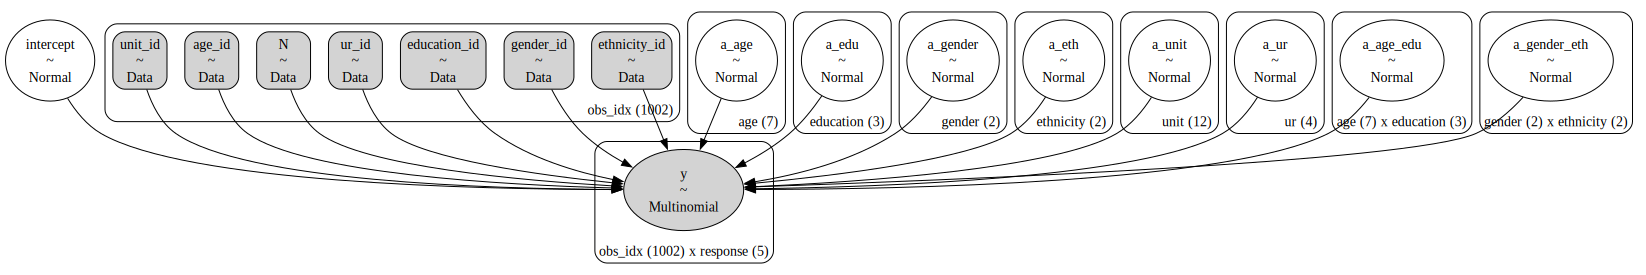

In [5]:
# What are we interested in predicting?
dependent_col = 'ukraina'

with pm.Model(coords=COORDS) as model:

    # --------------------------------------------------------
    #                   Intercepts
    # --------------------------------------------------------

    # intercept (i.e national) latent popularity for each response
    intercept = pm.Normal("intercept", sigma=1.5)

    # We collect all effects here. It will be of dimension (obs_idx, response)
    mu = intercept

    # --------------------------------------------------------
    #                   DATA COMPONENTS
    # --------------------------------------------------------
    sigma = 0.5

    # Declare inputs as Data so we can change them in post-stratification
    age_id = pm.Data("age_id", age_idx, dims="obs_idx")
    a_age = pm.Normal("a_age", sigma=sigma, dims="age")
    mu += a_age[age_id]

    education_id = pm.Data("education_id", education_idx, dims="obs_idx")
    a_edu = pm.Normal("a_edu", sigma=sigma, dims="education")
    mu += a_edu[education_id]

    gender_id = pm.Data("gender_id", gender_idx, dims="obs_idx")
    a_gender = pm.Normal("a_gender", sigma=sigma, dims="gender")
    mu += a_gender[gender_id]

    ethnicity_id = pm.Data("ethnicity_id", ethnicity_idx, dims="obs_idx")
    a_eth = pm.Normal("a_eth", sigma=sigma, dims="ethnicity")
    mu += a_eth[ethnicity_id]
    
    unit_id = pm.Data("unit_id", unit_idx, dims="obs_idx")
    a_unit = pm.Normal("a_unit", sigma=sigma, dims="unit")
    mu += a_unit[unit_id]

    ur_id = pm.Data("ur_id", ur_idx, dims="obs_idx")
    a_ur = pm.Normal("a_ur", sigma=sigma, dims="ur")
    mu += a_ur[ur_id]

    # We can also add interaction terms:
    a_age_edu = pm.Normal(
        "a_age_edu",
        sigma=0.5*sigma,
        dims=("age", "education"),
    )
    mu += a_age_edu[age_id, education_id]

    a_gender_eth = pm.Normal(
        "a_gender_eth",
        sigma=0.5*sigma,
        dims=("gender", "ethnicity"),
    )
    mu += a_gender_eth[gender_id, ethnicity_id]


    # --------------------------------------------------------
    #                   OBSERVATION MODEL
    # -------------------------------------------------------- 

    multinomial = True

    if multinomial == False: # Simple model, but hard to post-stratify

        resp_idx, resp_cat = data[dependent_col].factorize(sort=True)

        # Compute the p for each respondent
        p = pm.math.invlogit(mu)

        # Binomial observation model
        pm.Binomial("y", p=p, N=len(resp_cat)-1, observed=resp_idx)

    else: # Effectively the same model as above, but built for post-stratification

        # Create a mutable N and set it to 1 for now as we have one observation per person
        # This will be changed to the size of the census segment in post-stratification
        N = pm.Data("N", np.ones(len(data)), dims="obs_idx")

        # Convert the dependent variable to a dummy matrix
        obs = pd.get_dummies(data[dependent_col]).astype(int)

        # Add a coord for it as well
        model.add_coord('response',list(obs.columns))

        # Compute the p for each respondent
        p = pm.math.invlogit(mu)

        # This is hand-made, code in utils.py
        # It's the multivariate distribution of answers
        # IFF everyone answered according to a binomial distribution
        MvBinomial("y", p=p, N=len(obs.columns)-1, 
            n=N, observed=obs.values, dims=("obs_idx", "response"))

pm.model_to_graphviz(model)

In [6]:
with model:
    idata = pm.sample(nuts_sampler='nutpie') 
    pm.compute_log_likelihood(idata, extend_inferencedata=True)

trace_dict['linear'] = idata

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.19,31
,2000,0,0.20,127
,2000,0,0.20,95
,2000,0,0.20,191


Output()

In [7]:
# Save the fit
idata.to_netcdf('ord_mrp.nc')

'ord_mrp.nc'

/Users/tarmo/miniforge3/envs/salk/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['_offset', '_probs'] have not been found and will be ignored
  warnings.warn(


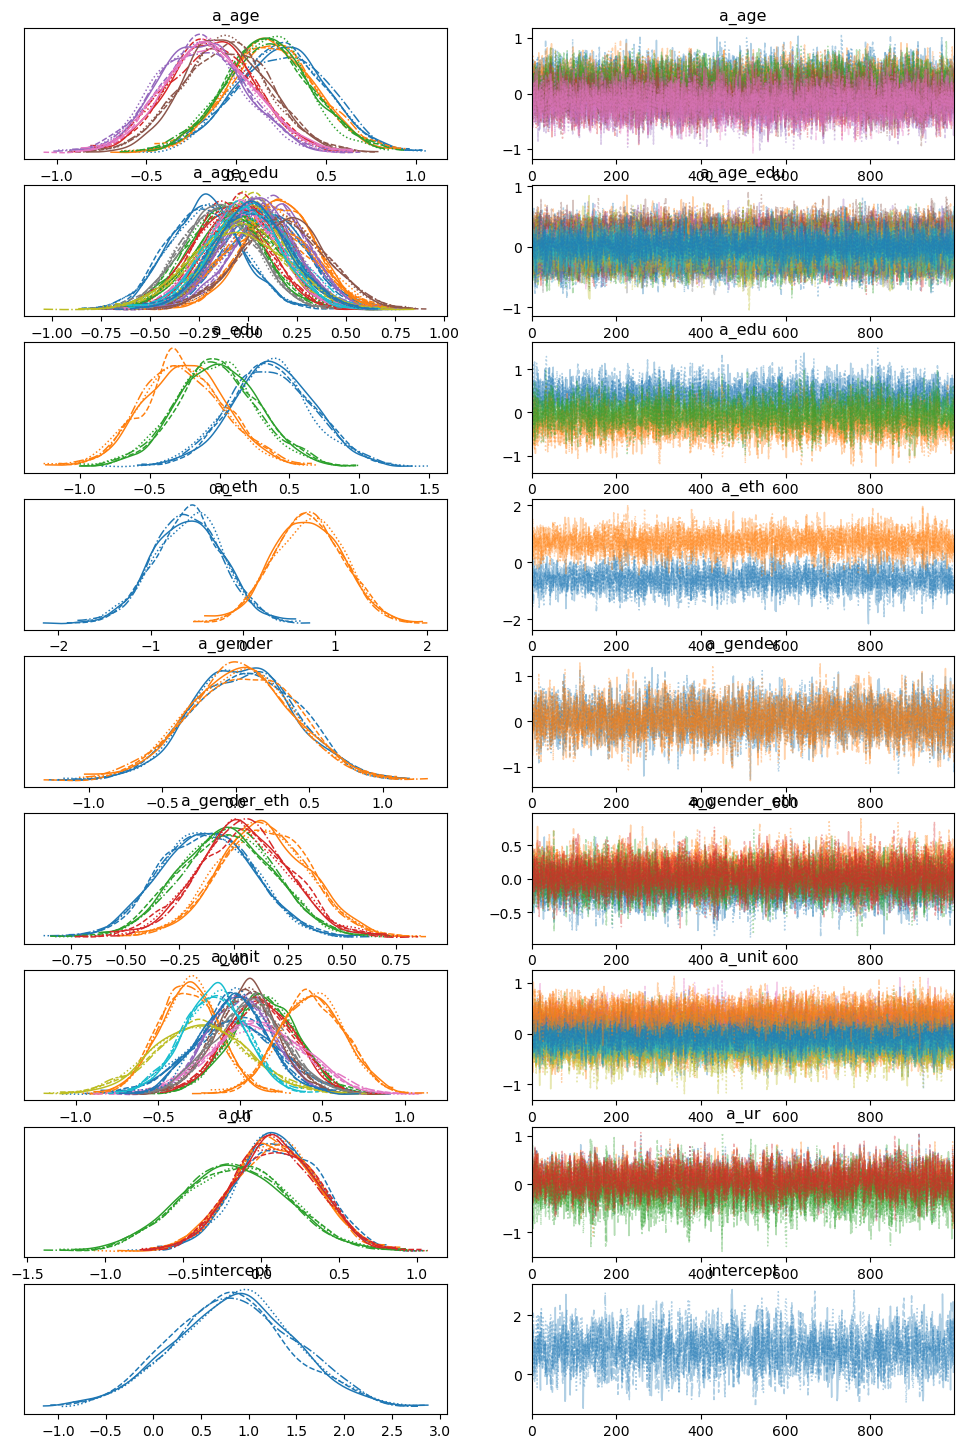

In [8]:
az.plot_trace(idata, var_names=["~_offset","~_probs"], filter_vars="regex");

# Post-stratification

### Process census data

In [9]:
cdata = pd.read_csv("./data/ee_census.csv")
cdata.head()

,Unnamed: 0,age_group,education,gender,nationality,electoral_district,unit,urban_rural,N
0,0,18-24,Secondary education,Male,Estonian,"Haabersti, Põhja-Tallinn ja Kristiine",Haabersti,Tallinn,519
1,1,18-24,Higher education,Male,Estonian,"Haabersti, Põhja-Tallinn ja Kristiine",Haabersti,Tallinn,62
2,2,18-24,Basic education,Male,Estonian,"Haabersti, Põhja-Tallinn ja Kristiine",Haabersti,Tallinn,269
3,3,18-24,Secondary education,Male,Estonian,"Kesklinn, Lasnamäe ja Pirita",Kesklinn,Tallinn,656
4,4,18-24,Higher education,Male,Estonian,"Kesklinn, Lasnamäe ja Pirita",Kesklinn,Tallinn,84


In [10]:
# Drop 0 values
cdata = cdata[cdata.N > 0]
print(len(cdata))

# Merge over all the columns that are present in both dataframes
shared_cols = [c for c in cdata.columns if c in data.columns]
cdata = cdata.groupby(shared_cols)['N'].sum().reset_index()

cdata.head()

3789


,age_group,education,gender,nationality,electoral_district,urban_rural,N
0,18-24,Basic education,Female,Estonian,"Haabersti, Põhja-Tallinn ja Kristiine",Tallinn,672
1,18-24,Basic education,Female,Estonian,Harju- ja Raplamaa,Rural,1111
2,18-24,Basic education,Female,Estonian,Harju- ja Raplamaa,Small town,372
3,18-24,Basic education,Female,Estonian,Harju- ja Raplamaa,Urban,295
4,18-24,Basic education,Female,Estonian,"Hiiu-, Lääne- ja Saaremaa",Rural,308


In [11]:
# Check that the columns that are present in both have matching category values
for c in cdata.columns[:-1]:
    s1, s2 = set(data[c].unique()), set(cdata[c].unique())
    if s1 != s2:
        print(c, s1-s2, s2-s1)


### Define new dimensions and coordinates

In [12]:

# I'm surprised pandas does not have this function but I could not find it. 
def factorize_w_codes(s, codes):
    res = s.replace(dict(zip(codes,range(len(codes)))))
    if not s.isin(codes).all(): # Throw an exception if all values were not replaced
        vals = set(s) - set(codes)
        raise Exception(f'Codes for {s.name} do not match all values: {vals}')
    return res.to_numpy()

In [13]:
poststrat_age_idx = factorize_w_codes(cdata["age_group"],ages)
poststrat_education_idx = factorize_w_codes(cdata["education"],educations)
poststrat_gender_idx = factorize_w_codes(cdata["gender"],genders)
poststrat_ethnicity_idx = factorize_w_codes(cdata["nationality"],ethnicities)
poststrat_units_idx = factorize_w_codes(cdata["electoral_district"],units)
poststrat_ur_idx = factorize_w_codes(cdata["urban_rural"],ur_responses)

### Condition model on new data

In [14]:
new_data = {
            "age_id": poststrat_age_idx,
            "education_id": poststrat_education_idx,
            "gender_id": poststrat_gender_idx,
            "ethnicity_id": poststrat_ethnicity_idx,
            "unit_id": poststrat_units_idx,
            "ur_id":poststrat_ur_idx,
            # "obs": np.zeros(
            #     (len(cdata.index), len(y_cols), len(y_options) ),
            #     dtype=int,
            # ),  # just a placeholder for new data size
            "N": cdata["N"].to_numpy(),
        }

with model:
    pm.set_data(
        coords={
            "obs_idx": cdata.index,
        },
        new_data=new_data
    )
    
    print("Sampling posterior predictive on census data")
    # Reduce the sample to just 100 draws from 2 chains each
    idata_s = idata.sel(draw=slice(0,500),chain=[0,1])
    idata_ps = pm.sample_posterior_predictive(
        idata_s,
        predictions=True
    )

Sampling: [y]


Output()

Sampling posterior predictive on census data


### Create the "Synthetic Population"

In [15]:
pred = idata_ps.predictions.y

# This needed some technical work to not explode memory usage
df = pd.DataFrame(
    pred.values.reshape(-1), dtype=pd.Int16Dtype(),
    columns=['N']
).assign(
    chain=np.repeat(pred.chain.values, len(pred.draw) * len(pred.obs_idx)*len(pred.response)).astype('int8'),
    draw=np.tile(np.repeat(pred.draw.values, len(pred.obs_idx)*len(pred.response)), len(pred.chain)).astype('int16'),
    obs_idx=np.tile(pred.obs_idx.values, len(pred.chain) * len(pred.draw)*len(pred.response)).astype('int16'),
    response=np.tile(np.arange(len(pred.response)), len(pred.chain) * len(pred.draw)*len(pred.obs_idx)).astype('int8')
)
df['adraw'] = df['draw'] + df['chain'] * len(pred.draw)
#df.memory_usage(deep=True)

# Sample a "synthetic population" of 1M rows by sampling with replacement with weights based on N
df = df.sample(weights='N',n=1000000,replace=True).drop(columns=['N'])
df['response'] = pd.Categorical(pred.response.values[df['response']],categories=pred.response.values,ordered=True)

# Merge with the census data on obs_idx
df = df.merge(cdata,left_on='obs_idx',right_index=True)
df = df.drop(columns=['obs_idx','N','chain','draw'])

# Explore synthetic data

In [16]:
# The synthetic population is now ready to be used for analysis
df.head()

,response,adraw,age_group,education,gender,nationality,electoral_district,urban_rural
2694611,Disagree,236,35-44,Higher education,Male,Other,Harju- ja Raplamaa,Rural
8139808,Agree,714,55-64,Higher education,Male,Other,Mustamäe ja Nõmme,Tallinn
7283796,Disagree,639,18-24,Higher education,Female,Estonian,"Hiiu-, Lääne- ja Saaremaa",Rural
5061632,Don't know,444,75+,Secondary education,Male,Other,"Haabersti, Põhja-Tallinn ja Kristiine",Tallinn
3025586,Disagree,265,55-64,Basic education,Male,Estonian,"Hiiu-, Lääne- ja Saaremaa",Rural


In [17]:
agg = (df.groupby(['response','adraw']).size()/df.groupby('adraw').size()).reset_index(name='p')

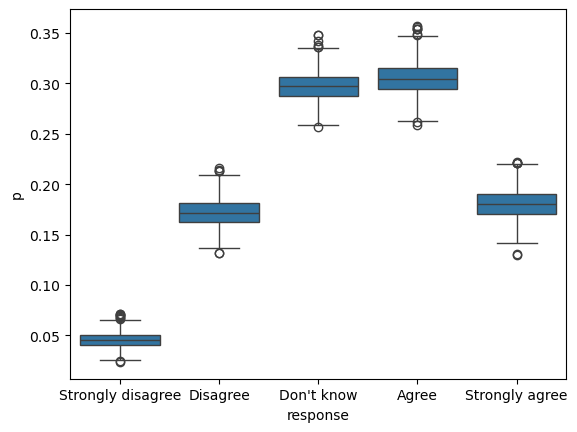

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x='response', y='p', data=agg)
plt.show()

In [19]:
plot = alt.Chart(agg.sample(5000)).mark_boxplot().encode(
    x=alt.X('response').sort(cats).title('Response'),
    y=alt.Y('p').title('Proportion')
).properties(
    title='Distribution of Response Proportions (Synthetic Population)',
    width=400,
    height=300
)

ticks = alt.Chart(data[dependent_col].value_counts(normalize=True).reset_index(name='p')).mark_bar(color='red', size=50).encode(
    x=alt.X(dependent_col).sort(cats).title('Response'),
    y='p'
).properties(
    title=f'Distribution of Response Proportions (Data)',
    width=400,
    height=300
)

plot | ticks

alt.HConcatChart(...)

In [20]:
# Draw young urban female highly educated only
fquery = "gender == 'Female' and age_group.isin(['18-24','25-34']) and education == 'Higher education'"

print(f"N in original data: {len(data.query(fquery))}")
print(f"N in synthetic population: {len(df.query(fquery))}")

f_df = df.query(fquery)
agg = (f_df.groupby(['response','adraw']).size()/f_df.groupby('adraw').size()).reset_index(name='p')

plot = alt.Chart(agg.sample(5000)).mark_boxplot().encode(
    x=alt.X('response').sort(cats).title('Response'),
    y=alt.Y('p').title('Proportion')
).properties(
    title='Distribution of Response Proportions',
    width=400,
    height=300
)

check = alt.Chart(data.query(fquery)[dependent_col].value_counts(normalize=True).reset_index(name='p')).mark_bar(color='red', size=50).encode(
    x=alt.X(dependent_col).sort(cats).title('Response'),
    y='p'
).properties(
    title=f'Distribution of Response Proportions (Data, n={len(data.query(fquery))})',
    width=400,
    height=300
)

plot | check

N in original data: 31
N in synthetic population: 56107


alt.HConcatChart(...)

In [21]:
# Draw young urban female highly educated only
fquery = "gender == 'Male' and age_group.isin(['75+']) and education == 'Secondary education'"

print(f"N in original data: {len(data.query(fquery))}")
print(f"N in synthetic population: {len(df.query(fquery))}")

f_df = df.query(fquery)
agg = (f_df.groupby(['response','adraw']).size()/f_df.groupby('adraw').size()).reset_index(name='p')

alt.Chart(agg.sample(5000)).mark_boxplot().encode(
    x=alt.X('response').sort(cats).title('Response'),
    y=alt.Y('p').title('Proportion')
).properties(
    title='Distribution of Response Proportions',
    width=400,
    height=300
)

N in original data: 18
N in synthetic population: 16253


alt.Chart(...)

# Other likelihoods for Order

In [31]:
# What are we interested in predicting?
dependent_col = "ukraina"
model_type = 'stereotype'

with pm.Model(coords=COORDS) as model:

    # --------------------------------------------------------
    #                   Intercepts
    # --------------------------------------------------------

    # intercept (i.e national) latent popularity for each response
    intercept = pm.Normal("intercept", sigma=1.5)

    # We collect all effects here. It will be of dimension (obs_idx, response)
    mu = intercept

    # --------------------------------------------------------
    #                   DATA COMPONENTS
    # --------------------------------------------------------
    sigma = 0.5

    # Declare inputs as Data so we can change them in post-stratification
    age_id = pm.Data("age_id", age_idx, dims="obs_idx")
    a_age = pm.Normal("a_age", sigma=sigma, dims="age")
    mu += a_age[age_id]

    education_id = pm.Data("education_id", education_idx, dims="obs_idx")
    a_edu = pm.Normal("a_edu", sigma=sigma, dims="education")
    mu += a_edu[education_id]

    gender_id = pm.Data("gender_id", gender_idx, dims="obs_idx")
    a_gender = pm.Normal("a_gender", sigma=sigma, dims="gender")
    mu += a_gender[gender_id]

    ethnicity_id = pm.Data("ethnicity_id", ethnicity_idx, dims="obs_idx")
    a_eth = pm.Normal("a_eth", sigma=sigma, dims="ethnicity")
    mu += a_eth[ethnicity_id]
    
    unit_id = pm.Data("unit_id", unit_idx, dims="obs_idx")
    a_unit = pm.Normal("a_unit", sigma=sigma, dims="unit")
    mu += a_unit[unit_id]

    ur_id = pm.Data("ur_id", ur_idx, dims="obs_idx")
    a_ur = pm.Normal("a_ur", sigma=sigma, dims="ur")
    mu += a_ur[ur_id]

    # We can also add interaction terms:
    a_age_edu = pm.Normal(
        "a_age_edu",
        sigma=0.5*sigma,
        dims=("age", "education"),
    )
    mu += a_age_edu[age_id, education_id]

    a_gender_eth = pm.Normal(
        "a_gender_eth",
        sigma=0.5*sigma,
        dims=("gender", "ethnicity"),
    )
    mu += a_gender_eth[gender_id, ethnicity_id]
    pm.Deterministic("mu", mu, dims="obs_idx")

    # --------------------------------------------------------
    #                   OBSERVATION MODEL
    # -------------------------------------------------------- 

    # Create a mutable N and set it to 1 for now as we have one observation per person
    # This will be changed to the size of the census segment in post-stratification
    N = pm.Data("N", np.ones(len(data)), dims="obs_idx")

    # Convert the dependent variable to a dummy matrix
    obs = pd.get_dummies(data[dependent_col]).astype(int)
    model.add_coord('response',list(obs.columns))

    # Binomial observation model
    if model_type == 'binomial':
        p = pm.math.invlogit(mu)
        MvBinomial("y", p=p, N=len(obs.columns)-1, 
            n=N, observed=obs.values, dims=("obs_idx", "response"))
            
    # Ordered Multinomial observation model (Logit-based)
    elif model_type == 'ordered-logit':
        # Model for cutpoints
        cp_scale = pm.HalfNormal(f"cutpoint_sd", sigma=2)
        cp_len = len(obs.columns)-1
        
        cutpoints = pm.ZeroSumNormal(
            "cutpoints",
            sigma=cp_scale,
            transform=pm.distributions.transforms.ordered,
            initval=np.linspace(-1,1,cp_len),
            shape=cp_len
        )

        # Ordered Multinomial observation model (Logit-based)
        pm.OrderedMultinomial(
            "y",
            eta=mu,
            cutpoints=cutpoints,
            n=N,
            observed=obs.values,
            dims=("obs_idx", "response"),
        )

    # Stereotype regression
    elif model_type == 'stereotype':

        # Generate phi values: first is 0, last is 1 and the inbetween is increasing
        n_ordered = len(obs.columns)
        phi_delta = pm.Dirichlet(f'phi_diffs', [1.0]*(n_ordered-1) )
        phi = pt.concatenate([[0], pt.cumsum(phi_delta)])

        # Create baseline values
        b = (pm.Normal("stereotype_intercept", size=n_ordered, 
                                transform=pm.distributions.transforms.ZeroSumTransform([-1])))

        # Log_odds = baseline + phi*mu
        log_odds = b[None,:] + phi[None,:]*mu[:,None]
        
        # Run them through softmax
        probs = pm.math.softmax(log_odds, axis=-1)

        pm.Multinomial("y", p=probs, n=N, observed=obs.values, dims=("obs_idx", "response"))

# Do the same thing as above for post-stratification. Code in utils.py
df_om, idata_om = poststratify(model,cdata,new_data)

trace_dict['stereotype'] = idata_om

Sampling model...


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.25,31
,2000,0,0.24,31
,2000,0,0.23,31
,2000,0,0.24,31


Output()

Computing log-likelihood...


Sampling: [y]


Output()

Sampling posterior predictive on census data...


Sampling synthetic population...


In [32]:
# Draw young urban female highly educated only
fquery = "gender == 'Male' and age_group.isin(['65-74', '75+']) and nationality == 'Other'"


print(f"N in original data: {len(data.query(fquery))}")
print(f"N in synthetic population: {len(df_om.query(fquery))}")

f_df = df_om.query(fquery)
agg = (f_df.groupby(['response','adraw']).size()/f_df.groupby('adraw').size()).reset_index(name='p')

agg['response'] = pd.Categorical(agg['response'], ordered=True)

alt.Chart(agg.sample(5000)).mark_boxplot().encode(
    x=alt.X('response').sort(cats).title('Response'),
    y=alt.Y('p').title('Proportion')
).properties(
    title='Distribution of Response Proportions',
    width=400,
    height=300
)

N in original data: 15
N in synthetic population: 63071


alt.Chart(...)

In [33]:
f_data = data.query(fquery)

p1 = alt.Chart(f_data, title='Data').mark_bar().encode(
    x=alt.X(dependent_col).sort(cats),
    y='count()',
).properties(
    width=400,
    height=400
)

p2 = alt.Chart(f_df.sample(1000), title='Synthetic population').mark_bar().encode(
    x=alt.X('response').sort(cats),
    y='count()',
).properties(
    width=400,
    height=400
)

p1 | p2

alt.HConcatChart(...)

# Hierarchical block

In [34]:
# A hierarchical building block for the model    
def hierarchical_zsn(name: str, dim: str, sigma: float = 0.2):

    scale = pm.HalfNormal(f"{name}_sd", sigma=sigma)
    offset = pm.ZeroSumNormal(f"{name}_offset", dims=dim)
    
    # Effect = scale * offset
    return pm.Deterministic(f"{name}", scale * offset, dims=(dim))

# Improved model

In [35]:
# What are we interested in predicting?
dependent_col = 'e-valimised'
model_type = 'stereotype'

with pm.Model(coords=COORDS) as model:

    # --------------------------------------------------------
    #                   Intercepts
    # --------------------------------------------------------

    # intercept (i.e national) latent popularity for each response
    intercept = pm.Normal("intercept", sigma=2)

    # We collect all effects here. It will be of dimension (obs_idx, response)
    mu = intercept

    # --------------------------------------------------------
    #                   DATA COMPONENTS
    # --------------------------------------------------------
    sigma = 0.5

    # Declare inputs as Data so we can change them in post-stratification
    age_id = pm.Data("age_id", age_idx, dims="obs_idx")
    a_age = hierarchical_zsn("a_age", "age", sigma=sigma)
    mu += a_age[age_id]

    education_id = pm.Data("education_id", education_idx, dims="obs_idx")
    a_edu = hierarchical_zsn("a_edu", "education", sigma=sigma)
    mu += a_edu[education_id]

    gender_id = pm.Data("gender_id", gender_idx, dims="obs_idx")
    a_gender = hierarchical_zsn("a_gender", "gender", sigma=sigma)
    mu += a_gender[gender_id]

    ethnicity_id = pm.Data("ethnicity_id", ethnicity_idx, dims="obs_idx")
    a_eth = hierarchical_zsn("a_eth", "ethnicity", sigma=sigma)
    mu += a_eth[ethnicity_id]
    
    unit_id = pm.Data("unit_id", unit_idx, dims="obs_idx")
    a_unit = hierarchical_zsn("a_unit", "unit", sigma=sigma)
    mu += a_unit[unit_id]

    ur_id = pm.Data("ur_id", ur_idx, dims="obs_idx")
    a_ur = hierarchical_zsn("a_ur", "ur", sigma=sigma)
    mu += a_ur[ur_id]


    # We can also add interaction terms:
    a_age_edu = pm.ZeroSumNormal(
        "a_age_edu",
        sigma=0.5*sigma,
        dims=("age", "education"),
        n_zerosum_axes=2,
    )
    mu += a_age_edu[age_id, education_id]

    a_gender_eth = pm.ZeroSumNormal(
        "a_gender_eth",
        sigma=0.5*sigma,
        dims=("gender", "ethnicity"),
        n_zerosum_axes=2,
    )
    mu += a_gender_eth[gender_id, ethnicity_id]

    pm.Deterministic("mu", mu, dims="obs_idx")

    # --------------------------------------------------------
    #                   OBSERVATION MODEL
    # -------------------------------------------------------- 

    # Create a mutable N and set it to 1 for now as we have one observation per person
    # This will be changed to the size of the census segment in post-stratification
    N = pm.Data("N", np.ones(len(data)), dims="obs_idx")

    # Convert the dependent variable to a dummy matrix
    obs = pd.get_dummies(data[dependent_col]).astype(int)
    model.add_coord('response',list(obs.columns))

    # Binomial observation model
    if model_type == 'binomial':
        p = pm.math.invlogit(mu)
        MvBinomial("y", p=p, N=len(obs.columns)-1, 
            n=N, observed=obs.values, dims=("obs_idx", "response"))
            
    # Ordered Multinomial observation model (Logit-based)
    elif model_type == 'ordered-logit':
        # Model for cutpoints
        cp_scale = pm.HalfNormal(f"cutpoint_sd", sigma=2)
        cp_len = len(obs.columns)-1
        
        cutpoints = pm.ZeroSumNormal(
            "cutpoints",
            sigma=cp_scale,
            transform=pm.distributions.transforms.ordered,
            initval=np.linspace(-1,1,cp_len),
            shape=cp_len
        )

        # Ordered Multinomial observation model (Logit-based)
        pm.OrderedMultinomial(
            "y",
            eta=mu,
            cutpoints=cutpoints,
            n=N,
            observed=obs.values,
            dims=("obs_idx", "response"),
        )

    # Stereotype regression
    elif model_type == 'stereotype':

        # Generate phi values: first is 0, last is 1 and the inbetween is increasing
        n_ordered = len(obs.columns)
        phi_delta = pm.Dirichlet(f'phi_diffs', [1.0]*(n_ordered-1) )
        phi = pt.concatenate([[0], pt.cumsum(phi_delta)])

        # Create baseline values
        b = (pm.Normal("stereotype_intercept", size=n_ordered, 
                                transform=pm.distributions.transforms.ZeroSumTransform([-1])))

        # Log_odds = baseline + phi*mu
        log_odds = b[None,:] + phi[None,:]*mu[:,None]
        
        # Run them through softmax
        probs = pm.math.softmax(log_odds, axis=-1)

        pm.Multinomial("y", p=probs, n=N, observed=obs.values, dims=("obs_idx", "response"))

# Do the same thing as above for post-stratification. Code in utils.py
df2, idata2 = poststratify(model,cdata,new_data)

trace_dict['hierarchical'] = idata2


Sampling model...


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.24,15
,2000,0,0.25,15
,2000,0,0.25,31
,2000,0,0.24,31


Computing log-likelihood...


Output()

Sampling: [y]


Output()

Sampling posterior predictive on census data...


Sampling synthetic population...


In [36]:
# Draw young urban female highly educated only
fquery = "gender == 'Male' and nationality == 'Other' and electoral_district == 'Tartu linn'"

print(f"N in original data: {len(data.query(fquery))}")
print(f"N in synthetic population: {len(df2.query(fquery))}")

f_df = df2.query(fquery)
agg = (f_df.groupby(['response','adraw']).size()/f_df.groupby('adraw').size()).reset_index(name='p')

alt.Chart(agg.sample(5000)).mark_boxplot().encode(
    x=alt.X('response').sort(cats).title('Response'),
    y=alt.Y('p').title('Proportion')
).properties(
    title='Distribution of Response Proportions',
    width=400,
    height=300
)

ticks = alt.Chart(data.query(fquery)[dependent_col].value_counts(normalize=True).reset_index(name='p')).mark_bar(color='red', size=50).encode(
    x=alt.X(dependent_col).sort(cats).title('Response'),
    y='p'
).properties(
    title=f'Distribution of Response Proportions (Data, n={len(data.query(fquery))})',
    width=400,
    height=300
)

plot | ticks

N in original data: 8
N in synthetic population: 12370


alt.HConcatChart(...)

# Regular (non-ordered) categoricals

In [37]:
# A hierarchical building block for the model    
def hierarchical_zsn_2d(name: str, dim: str, odim = "question", sigma: float = 0.2):

    scale = pm.HalfNormal(f"{name}_sd", sigma=sigma, dims=odim) # Separate sd per output category
    offset = pm.ZeroSumNormal(f"{name}_offset", dims=(dim,odim), n_zerosum_axes=2)

    return pm.Deterministic(f"{name}", scale[None,:] * offset, dims=(dim,odim))

In [38]:
# What are we interested in predicting?
dependent_col = 'e-valimised' # You CAN do this with ordered, but it will be noisier

with pm.Model(coords=COORDS) as model:

    # Convert the dependent variable to a dummy matrix
    obs = pd.get_dummies(data[dependent_col]).astype(int)
    model.add_coord('response',list(obs.columns))

    # --------------------------------------------------------
    #                   Intercepts
    # --------------------------------------------------------

    # intercept (i.e national) latent popularity for each response
    intercept_sd = pm.HalfNormal("intercept_sd", 2)
    intercept = pm.Normal("intercept", sigma=intercept_sd, dims="response")

    # We collect all effects here. It will be of dimension (obs_idx, response)
    mu = intercept[None,:]

    # --------------------------------------------------------
    #                   DATA COMPONENTS
    # --------------------------------------------------------
    sigma = 0.5

    # Declare inputs as Data so we can change them in post-stratification
    age_id = pm.Data("age_id", age_idx, dims="obs_idx")
    a_age = hierarchical_zsn_2d("a_age", "age", odim="response", sigma=sigma)
    mu += a_age[age_id]

    education_id = pm.Data("education_id", education_idx, dims="obs_idx")
    a_edu = hierarchical_zsn_2d("a_edu", "education", odim="response", sigma=sigma)
    mu += a_edu[education_id]

    gender_id = pm.Data("gender_id", gender_idx, dims="obs_idx")
    a_gender = hierarchical_zsn_2d("a_gender", "gender", odim="response", sigma=sigma)
    mu += a_gender[gender_id]

    ethnicity_id = pm.Data("ethnicity_id", ethnicity_idx, dims="obs_idx")
    a_eth = hierarchical_zsn_2d("a_eth", "ethnicity", odim="response", sigma=sigma)
    mu += a_eth[ethnicity_id]
    
    unit_id = pm.Data("unit_id", unit_idx, dims="obs_idx")
    a_unit = hierarchical_zsn_2d("a_unit", "unit", odim="response", sigma=sigma)
    mu += a_unit[unit_id]

    ur_id = pm.Data("ur_id", ur_idx, dims="obs_idx")
    a_ur = hierarchical_zsn_2d("a_ur", "ur", odim="response", sigma=sigma)
    mu += a_ur[ur_id]

    # We can also add interaction terms:
    a_age_edu = pm.ZeroSumNormal(
        "a_age_edu",
        sigma=0.5*sigma,
        dims=("age", "education", "response"),
        n_zerosum_axes=3,
    )
    mu += a_age_edu[age_id, education_id]

    a_gender_eth = pm.ZeroSumNormal(
        "a_gender_eth",
        sigma=0.5*sigma,
        dims=("gender", "ethnicity", "response"),
        n_zerosum_axes=3,
    )
    mu += a_gender_eth[gender_id, ethnicity_id]

    pm.Deterministic("mu", mu, dims=("obs_idx","response"))

    # Create a mutable N and set it to 1 for now as we have one observation per person
    # This will be changed to the size of the census segment in post-stratification
    N = pm.Data("N", np.ones(len(data)), dims="obs_idx")

    # Softmax: pm version fails for some reason
    # p = pm.math.softmax(mu)
    p = pt.exp(mu)
    p/= pt.sum(p, axis=-1, keepdims=True)
    
    pm.Multinomial("y", n=N, p=p, observed=obs.values, dims=("obs_idx", "response"))

df3, idata3 = poststratify(model,cdata,new_data)

trace_dict['multinomial'] = idata3

Sampling model...


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.23,15
,2000,0,0.24,15
,2000,0,0.23,15
,2000,0,0.23,15


Computing log-likelihood...


Output()

Sampling: [y]


Output()

Sampling posterior predictive on census data...


Sampling synthetic population...


# Model comparison

              rank     elpd_loo      p_loo   elpd_diff    weight         se  \
stereotype       0 -1393.965804  26.353953    0.000000  0.512377  20.106908   
multinomial      1 -1399.484425  66.724320    5.518620  0.487623  19.975332   
hierarchical     2 -1400.256919  25.082517    6.291115  0.000000  19.332679   
linear           3 -1646.206990  56.775374  252.241186  0.000000  30.445262   

                    dse  warning scale  
stereotype     0.000000    False   log  
multinomial   26.112081    False   log  
hierarchical  25.445961    False   log  
linear        21.037275    False   log  


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

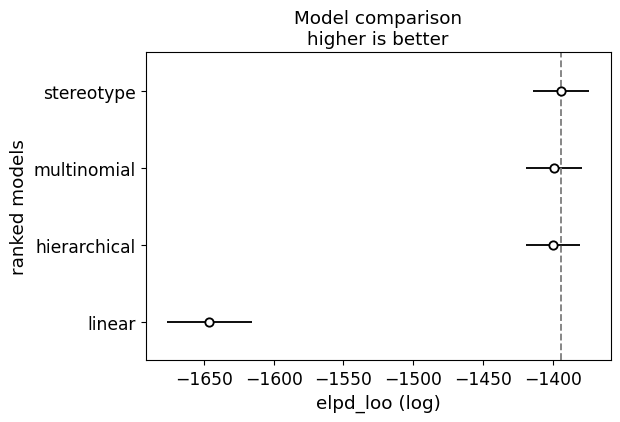

In [39]:
c = az.compare(trace_dict, ic='loo')
print(c)
az.plot_compare(c)